# Proyecto individual: Sistema de recomendación de películas
​
Este proyecto constará de dos fases: `Ingenieria de datos`, `Modelamiento y evaluación con machine learning`.

### 1. Ingeniería de datos
* Esto incluye la limpieza y transformación de los datos, abordando problemas como:
    * valores faltantes, 
    * datos duplicados y variables irrelevantes,
    * valores anidados,
    * formateo de columnas,
    * nubes de palabras para ver las más frecuentes.
    * a fin de mejorar la calidad del dataset para el modelado.
    * análisis univariado.
    * análisis bivariado y multivariado.
​
### 2. Modelamiento y evaluación con machine learning
* Implementar un modelo de clasificación con aprendizaje supervisado que permita clasificar (**con un algoritmo de coseno de similitud, por ejemplo**) las películas por ... para encontrar una lista de 5 películas similares 

### 1. Análisis exploratorio de datos
* Esto incluye la exploración de los datos y análisis de patrones para posteriormente desarrollar el modelo de recomendación de películas:
    * relaciones entre variables.
    * matriz de correlación.
    * outliers o anomalías.
    * análisis univariado.

#### 1.1. Importación de librerías

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

# Mostrar figuras de matplotlib en el entorno de Jupyter Notebook
%matplotlib inline

#### 1.2. Carga y visualización los datos

In [2]:
df_ml = pd.read_csv('dataset/data_movies_ml.csv')
df_ml.head(2)

,budget,overview,popularity,revenue,title,vote_average,vote_count,release_year,collection_name,studios_name,genres_name,return
0,30000000.0,"Led by Woody, Andy's toys live happily in his ...",21.95,373554033.0,Toy Story,7.7,5415.0,1995,Toy Story Collection,['Pixar Animation Studios'],"['Animation', 'Comedy', 'Family']",12.451801
1,65000000.0,When siblings Judy and Peter discover an encha...,17.02,262797249.0,Jumanji,6.9,2413.0,1995,Grumpy Old Men Collection,"['TriStar Pictures', 'Teitler Film', 'Intersco...","['Adventure', 'Fantasy', 'Family']",4.043035


#### 1.3. Descripción del DataFrame

In [3]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39901 entries, 0 to 39900
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   budget           39901 non-null  float64
 1   overview         23751 non-null  object 
 2   popularity       23802 non-null  float64
 3   revenue          39901 non-null  float64
 4   title            23802 non-null  object 
 5   vote_average     23802 non-null  float64
 6   vote_count       39901 non-null  float64
 7   release_year     39901 non-null  int64  
 8   collection_name  2445 non-null   object 
 9   studios_name     24413 non-null  object 
 10  genres_name      34637 non-null  object 
 11  return           39901 non-null  float64
dtypes: float64(6), int64(1), object(5)
memory usage: 3.7+ MB


#### 1.4. Eliminación de variables cualitativas

In [4]:
df_ml = df_ml.drop(['collection_name', 'overview'], axis=1)

In [5]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39901 entries, 0 to 39900
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   budget        39901 non-null  float64
 1   popularity    23802 non-null  float64
 2   revenue       39901 non-null  float64
 3   title         23802 non-null  object 
 4   vote_average  23802 non-null  float64
 5   vote_count    39901 non-null  float64
 6   release_year  39901 non-null  int64  
 7   studios_name  24413 non-null  object 
 8   genres_name   34637 non-null  object 
 9   return        39901 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.0+ MB


#### 1.5. Eliminación de nulos

In [6]:
df_ml = df_ml.dropna()

In [7]:
df_ml.isnull().sum()

budget          0
popularity      0
revenue         0
title           0
vote_average    0
vote_count      0
release_year    0
studios_name    0
genres_name     0
return          0
dtype: int64

#### 1.6. Observaciones

* 1.6.1. Se observa que para realizar el modelo de machine learning, será necesario eliminar la variable collection_name dado que cuenta con pocos datos en relación con los demás. 
* 1.6.2. Se procederá a eliminar los nulos en las columnas restantes dado que se cuenta con muchos datos, cerca de 23000, suficiente para el modelo.
* 1.6.3. Hay variables categóricas que deberán ser convertidas en numéricas, pero considerando que se trata de un MVP, para no cargar el modelo, se procederá a eliminar también estas variables y virar a un modelo sencillo pero que funcione correctamente en render.
* 1.6.4. Se decide trabajar solo con variables numéricas, y realizar un features importance para ver las variables más importantes.

#### 1.7. Distribución de los valores en columnas numéricas en histogramas 

Configurando límites para budget: (0, 10000000.0)
Configurando límites para popularity: (0, 30)
Configurando límites para revenue: (0, 100000000.0)
Configurando límites para vote_average: (0, 10)
Configurando límites para vote_count: (0, 1500)
Configurando límites para release_year: (1980, 2025)
Configurando límites para return: (0, 1000000.0)


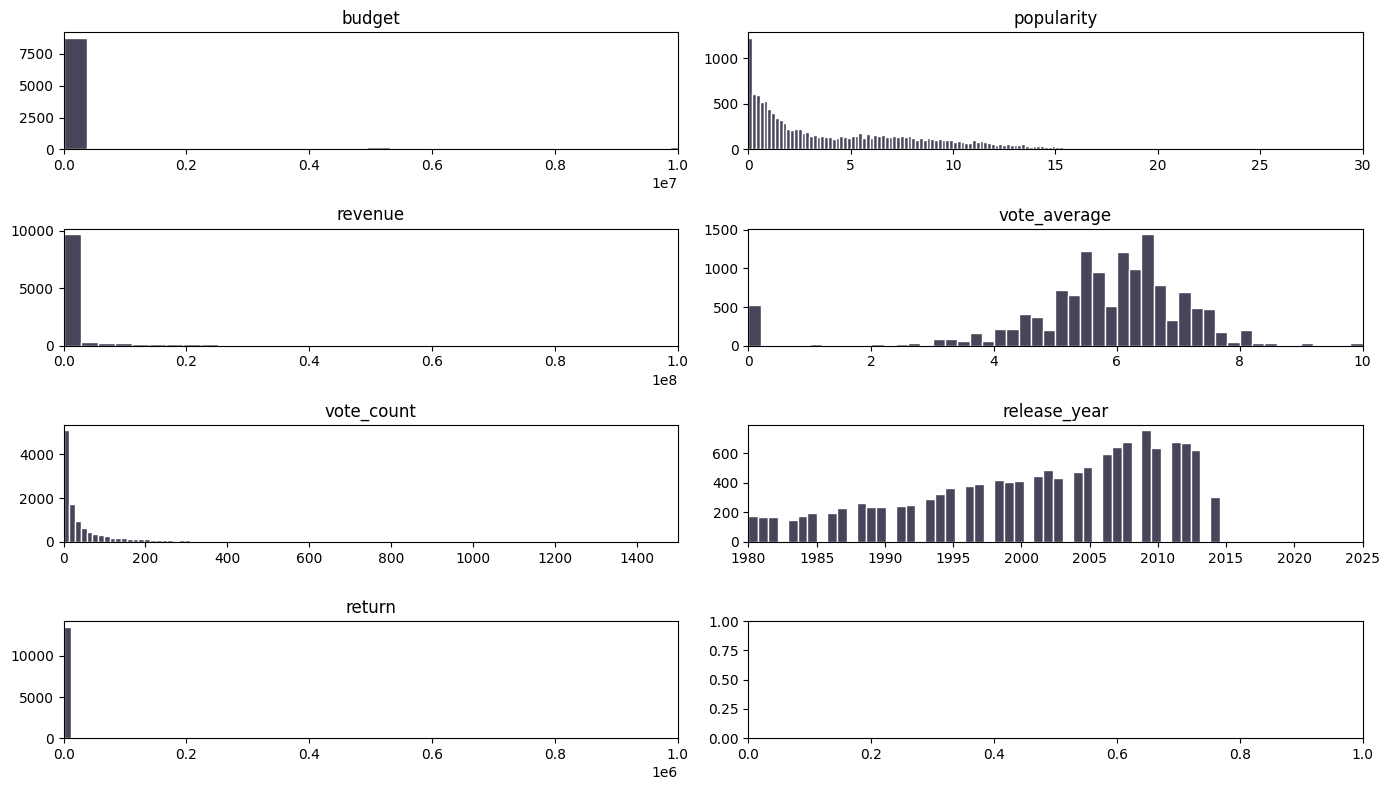

In [8]:
import matplotlib.pyplot as plt

# Búsqueda de valores atípicos (outliers) mediante histogramas
numeric_columns = df_ml.select_dtypes(include='number')
num_columns = len(numeric_columns.columns)

num_rows = (num_columns // 2) + (num_columns % 2)
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 8))

axes = axes.flatten()

# Definir límites personalizados para cada columna
limites = {
    'budget': (0, 1e7),
    'popularity': (0, 30),
    'revenue': (0, 1e8),
    'vote_count': (0, 1500),
    'return': (0, 1e6),
    'vote_average': (0, 10),
    'release_year': (1980, 2025)  
}

# Establecer el número de bins para cada columna
bins_dict = {
    'budget': 1000,
    'popularity': 1000,
    'revenue': 1000,
    'vote_count': 1000,
    'return': 1000,
    'vote_average': 50,
    'release_year': 50
}

for i, col in enumerate(numeric_columns.columns):
    bins = bins_dict.get(col, 100)  # Usar 100 bins por defecto si no está en el diccionario
    axes[i].hist(df_ml[col], bins=bins, color='#474559', edgecolor='white')
    axes[i].set_title(col)
    
    # Aplicar los límites si están definidos en el diccionario
    if col in limites:
        print(f"Configurando límites para {col}: {limites[col]}")
        axes[i].set_xlim(limites[col])

plt.tight_layout()
plt.show()


#### 1.8. Observaciones:
* 1.8.1 Se observa que las variables budget, revenue, vote_count y return presentan una distribución concentrada en valores inferiores, es decir, sesgada a la derecha. 
* 1.8.2. Se interpreta que estos valores anómalos, es decir, extremos a la derecha, corresponden al sector, ya que la mayoria de las peliculas cuentan con cierto capital, y muy pocas, gastan en demasía.
* 1.8.3. A priori, se decide no eliminar los outliers porque el sistema de recomendación se quedaria sin valores en los extremos y terminaría recomendando mal. Se examinará con boxplots

#### 1.9. Distribución de los valores en columnas numéricas en boxplots

Configurando límites para budget: (0, 10000000.0)
Configurando límites para popularity: (0, 300)
Configurando límites para revenue: (0, 2000000000.0)
Configurando límites para vote_average: (0, 10)
Configurando límites para vote_count: (0, 15000)
Configurando límites para release_year: (1980, 2025)
Configurando límites para return: (0, 15000000.0)


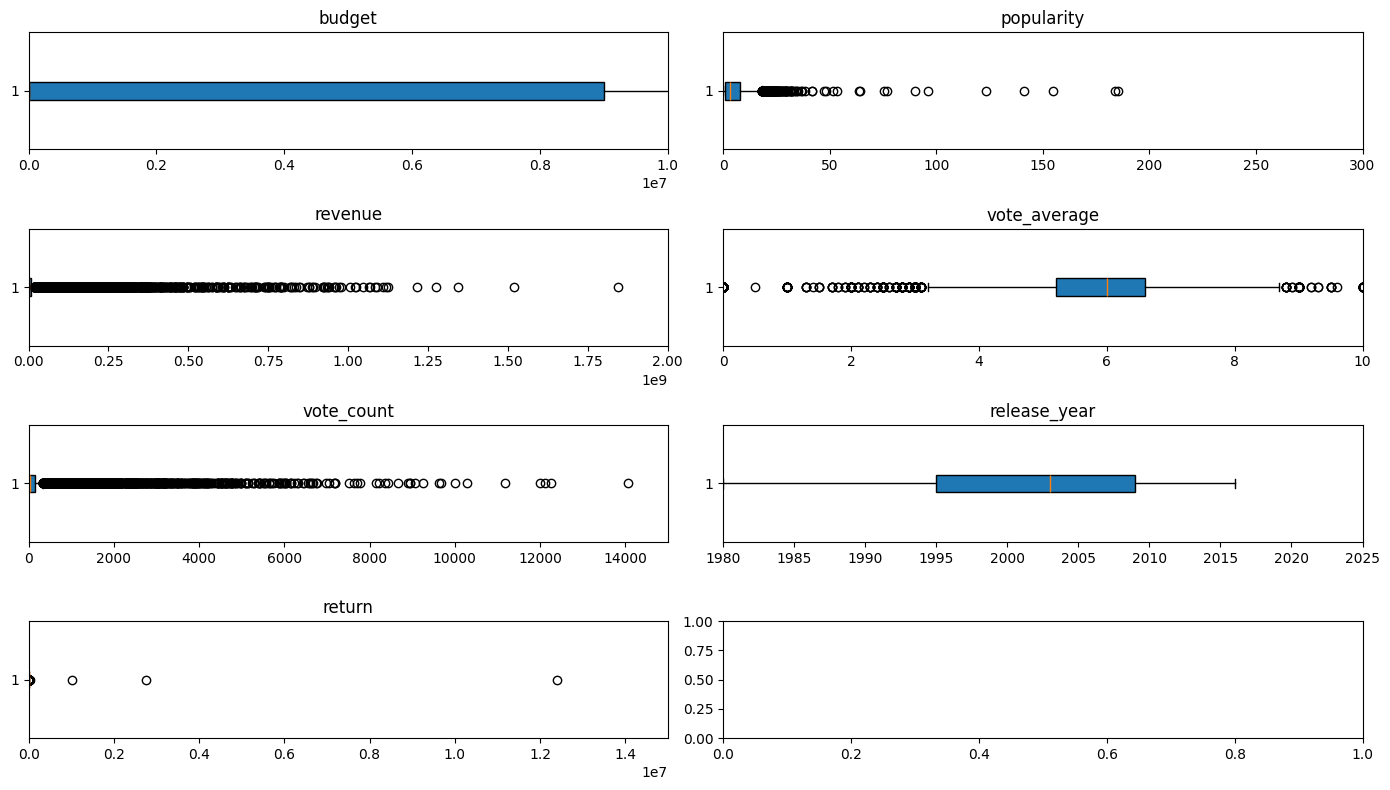

In [9]:
import matplotlib.pyplot as plt

# Búsqueda de valores atípicos (outliers) mediante boxplots
numeric_columns = df_ml.select_dtypes(include='number')
num_columns = len(numeric_columns.columns)

num_rows = (num_columns // 2) + (num_columns % 2)
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 8))

axes = axes.flatten()

# Definir límites personalizados para cada columna
limites = {
    'budget': (0, 1e7),
    'popularity': (0, 300),
    'revenue': (0, 2e9),
    'vote_count': (0, 15000),
    'return': (0, 1.5e7),
    'vote_average': (0, 10),
    'release_year': (1980, 2025)  
}

for i, col in enumerate(numeric_columns.columns):
    axes[i].boxplot(df_ml[col].dropna(), vert=False, patch_artist=True)
    axes[i].set_title(col)
    
    # Aplicar los límites si están definidos en el diccionario
    if col in limites:
        print(f"Configurando límites para {col}: {limites[col]}")
        axes[i].set_xlim(limites[col])

plt.tight_layout()
plt.show()


#### 1.10. Máximos en la variable return:

In [10]:
import pandas as pd

# Supongamos que df_ml es tu DataFrame
# Asegúrate de que el DataFrame tiene una columna llamada 'title' y 'return'

# Ordenar el DataFrame por la columna 'return' en orden descendente
df_sorted = df_ml.sort_values(by='return', ascending=False)

# Seleccionar las 10 películas con mayor 'return'
top_10_return = df_sorted[['title', 'return']].head(10)

print("Las 10 películas con mayor 'return' son:")
print(top_10_return)


Las 10 películas con mayor 'return' son:
                         title        return
2830            Less Than Zero  1.239638e+07
12489           Aquí Entre Nos  2.755584e+06
1732   The Karate Kid, Part II  1.018619e+06
9416        From Prada to Nada  2.688172e+04
8301       Paranormal Activity  1.289039e+04
5275                 Tarnation  5.330339e+03
1929   The Blair Witch Project  4.133333e+03
10663  Love, Wedding, Marriage  1.378000e+03
5088             Super Size Me  4.396166e+02
5741                Open Water  4.205227e+02


#### 1.11. Observaciones:
* 1.11.1 Se observa que existe las primeras 4 películas podrian ser eliminadas, dado que son verdaderamente, extremos, pero se dejará a que corra el modelo y se probará si conviene su eliminación o no.

#### 1.12. Análisis de duplicados

1.12.1. Se crean dos variables, una con duplicados y la otra sin duplicados. Se usará el dataframe sin duplicados

In [11]:
# Mostrar las filas duplicadas en la columna título
df_ml_cd = df_ml.duplicated(subset=['title'])
print("Filas duplicadas (basadas en todas la columna 'title'):") 
print(df_ml[df_ml_cd])

Filas duplicadas (basadas en todas la columna 'title'):
           budget  popularity      revenue                         title  \
1837          0.0       11.60          0.0                    True Crime   
2476    2000000.0       12.90    1568749.0                        Hamlet   
2545          0.0       12.50   20710451.0                        Hamlet   
2593          0.0        1.43          0.0                    Wonderland   
3361          0.0        0.01          0.0                        D.O.A.   
...           ...         ...          ...                           ...   
13408  50000000.0        9.09  160602194.0                Into the Storm   
13428         0.0        1.24          0.0  20,000 Leagues Under the Sea   
13434  13200000.0       24.64   53830415.0                  No Good Deed   
13439         0.0        0.18          0.0                     Catacombs   
13567         0.0        3.85          0.0               Sleeping Beauty   

       vote_average  vote_count

In [12]:
df_ml_sd = df_ml.drop_duplicates(subset=['title'])
df_ml_sd.head(2)

,budget,popularity,revenue,title,vote_average,vote_count,release_year,studios_name,genres_name,return
0,30000000.0,21.95,373554033.0,Toy Story,7.7,5415.0,1995,['Pixar Animation Studios'],"['Animation', 'Comedy', 'Family']",12.451801
1,65000000.0,17.02,262797249.0,Jumanji,6.9,2413.0,1995,"['TriStar Pictures', 'Teitler Film', 'Intersco...","['Adventure', 'Fantasy', 'Family']",4.043035


In [13]:
df_ml_sd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13236 entries, 0 to 13577
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   budget        13236 non-null  float64
 1   popularity    13236 non-null  float64
 2   revenue       13236 non-null  float64
 3   title         13236 non-null  object 
 4   vote_average  13236 non-null  float64
 5   vote_count    13236 non-null  float64
 6   release_year  13236 non-null  int64  
 7   studios_name  13236 non-null  object 
 8   genres_name   13236 non-null  object 
 9   return        13236 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 1.1+ MB


#### 1.13. Optimización del código

Debido a que el código se demora mucho para hacer el algoritmo, se opta por reducir la cantidad de filas

In [14]:
# Filtrar el DataFrame por la columna 'vote_average' con valores mayores a 3
df_ml_filter = df_ml_sd[df_ml_sd['vote_average'] > 3]

# Filtrar el DataFrame donde la columna return sea igual a 0 (esto quiere decir que o budget fue igual a 0 o revenue, y probablemente sean errores de carga de datos)
df_ml_filter = df_ml_filter[df_ml_filter['return'] > 0]

# Filtrar el DataFrame donde la columna renevue sea mayor a 1.75 e9 (hay pocos datos arriba de ellos y podría distorsionar el algoritmo de recomendación)
df_ml_filter = df_ml_filter[df_ml_filter['revenue'] < 1.75e9]

# Filtrar el DataFrame donde la columna return sea mayor a 1e5 (hay pocos datos arriba de ellos y podría distorsionar el algoritmo de recomendación)
df_ml_filter = df_ml_filter[df_ml_filter['return'] < 1e5]


In [15]:
# Ordenar el DataFrame por la columna 'budget' en orden ascendente
df_ml_filter.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3656 entries, 0 to 13576
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   budget        3656 non-null   float64
 1   popularity    3656 non-null   float64
 2   revenue       3656 non-null   float64
 3   title         3656 non-null   object 
 4   vote_average  3656 non-null   float64
 5   vote_count    3656 non-null   float64
 6   release_year  3656 non-null   int64  
 7   studios_name  3656 non-null   object 
 8   genres_name   3656 non-null   object 
 9   return        3656 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 314.2+ KB


In [24]:
df_ml_filter = df_ml_filter.to_csv('dataset/data_movies_ml.csv', index=False)

## 2. Modelamiento y evaluación

#### 2.1. Importación de la librería

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#### 2.2. Creación y entrenamiento del modelo considerando solo valores cualitativos

In [17]:
# Primero, vamos a convertir la columna 'title' a una representación numérica usando TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_ml_filter['title'])

# Luego, vamos a añadir las columnas numéricas a nuestra matriz de características
features = np.column_stack([tfidf_matrix.toarray(),
                            df_ml_filter['budget'], 
                            df_ml_filter['vote_average'], 
                            df_ml_filter['popularity'],
                            df_ml_filter['release_year']])

# Reindexamos el DataFrame
data = df_ml_filter.reset_index(drop=True)

# Ahora, calculamos la matriz de similitud de coseno
similarity_matrix = cosine_similarity(features)

# Para hacer recomendaciones, puedes buscar los productos más similares a un producto dado
name_title = "Babe"  # El nombre del producto para el que quieres hacer recomendaciones
name_films = data[data['title'] == name_title]

if not name_films.empty:
    product_index = name_films.index[0]
    product_similarities = similarity_matrix[product_index]
    
    # Se obtienen los índices de las 5 películas más similares (ordenados de forma descendente), excluyendo la propia película
    most_similar_films_indices = np.argsort(-product_similarities)[1:6]
    most_similar_films = data.loc[most_similar_films_indices, ['title', 'vote_average', 'popularity', 'release_year']]
    print(f"Las 5 películas más recomendadas para {name_title} son:")
    print(most_similar_films.to_string(index=False))
else:
    print("Película no encontrada")


Las 5 películas más recomendadas para Babe son:
                              title  vote_average  popularity  release_year
                    The Frighteners           6.7       12.09          1996
                Legends of the Fall           7.2       12.20          1994
                              Speed           6.8       10.86          1994
The Naked Gun 33⅓: The Final Insult           6.4       10.59          1994
                         Cool World           4.9       11.78          1992


In [18]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Vectorizar la columna 'title' usando TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_ml_filter['title'])

# Codificar la columna 'genres_name' usando MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(df_ml_filter['genres_name'])

# Luego, vamos a añadir las columnas numéricas y la matriz de géneros a nuestra matriz de características
features = np.column_stack([tfidf_matrix.toarray(),
                            df_ml_filter['budget'], 
                            df_ml_filter['vote_average'], 
                            df_ml_filter['popularity'],
                            df_ml_filter['release_year'],
                            genres_encoded])

# Reindexamos el DataFrame
data = df_ml_filter.reset_index(drop=True)

# Ahora, calculamos la matriz de similitud de coseno
similarity_matrix = cosine_similarity(features)

# Para hacer recomendaciones, puedes buscar los productos más similares a un producto dado
name_title = "Babe"  # El nombre de la película para la cual quieres hacer recomendaciones
name_films = data[data['title'] == name_title]

if not name_films.empty:
    product_index = name_films.index[0]
    product_similarities = similarity_matrix[product_index]
    
    # Se obtienen los índices de las 5 películas más similares (ordenados de forma descendente), excluyendo la propia película
    most_similar_products_indices = np.argsort(-product_similarities)[1:6]
    
    # Obtener los títulos, vote_average y release_year de las 5 películas más similares
    most_similar_products = data.loc[most_similar_products_indices, ['title', 'vote_average', 'genres_name', 'release_year']]
    
    print(f"Las 5 películas más recomendadas para {name_title} son:")
    print(most_similar_products.to_string(index=False))
else:
    print("Película no encontrada")


Las 5 películas más recomendadas para Babe son:
                              title  vote_average                     genres_name  release_year
                Legends of the Fall           7.2  ['Comedy', 'Drama', 'Romance']          1994
                    The Frighteners           6.7            ['Drama', 'Romance']          1996
The Naked Gun 33⅓: The Final Insult           6.4 ['Comedy', 'Family', 'Fantasy']          1994
                        Primal Fear           7.4         ['Adventure', 'Family']          1996
                              Speed           6.8  ['Comedy', 'Drama', 'Romance']          1994


In [19]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Vectorizar la columna 'title' usando TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_ml_filter['title'])

# Codificar la columna 'genres_name' y 'studios_name' usando MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(df_ml_filter['genres_name'])
studios_encoded = mlb.fit_transform(df_ml_filter['studios_name'])

# Luego, vamos a añadir las columnas numéricas y la matriz de géneros a nuestra matriz de características
features = np.column_stack([tfidf_matrix.toarray(),
                            df_ml_filter['budget'], 
                            df_ml_filter['vote_average'], 
                            df_ml_filter['popularity'],
                            df_ml_filter['release_year'],
                            genres_encoded,
                            studios_encoded])

# Reindexamos el DataFrame
data = df_ml_filter.reset_index(drop=True)

# Ahora, calculamos la matriz de similitud de coseno
similarity_matrix = cosine_similarity(features)

# Para hacer recomendaciones, puedes buscar los productos más similares a un producto dado
name_title = "Babe"  # El nombre de la película para la cual quieres hacer recomendaciones
name_films = data[data['title'] == name_title]

if not name_films.empty:
    product_index = name_films.index[0]
    product_similarities = similarity_matrix[product_index]
    
    # Se obtienen los índices de las 5 películas más similares (ordenados de forma descendente), excluyendo la propia película
    most_similar_products_indices = np.argsort(-product_similarities)[1:6]
    
    # Obtener los títulos, vote_average y release_year de las 5 películas más similares
    most_similar_products = data.loc[most_similar_products_indices, ['title', 'vote_average', 'genres_name', 'studios_name', 'release_year']]
    
    print(f"Las 5 películas más recomendadas para {name_title} son:")
    print(most_similar_products.to_string(index=False))
else:
    print("Película no encontrada")


Las 5 películas más recomendadas para Babe son:
                              title  vote_average                     genres_name                                                           studios_name  release_year
                Legends of the Fall           7.2  ['Comedy', 'Drama', 'Romance']                                                 ['Hollywood Pictures']          1994
                    The Frighteners           6.7            ['Drama', 'Romance']                                         ['Merchant Ivory Productions']          1996
The Naked Gun 33⅓: The Final Insult           6.4 ['Comedy', 'Family', 'Fantasy']    ['Paramount Pictures', 'Orion Pictures', 'Scott Rudin Productions']          1994
                        Primal Fear           7.4         ['Adventure', 'Family']         ['Universal Pictures', 'The Bubble Factory', 'American Films']          1996
                              Speed           6.8  ['Comedy', 'Drama', 'Romance'] ['Fine Line Features', 'Castle Rock

In [20]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Vectorizar la columna 'title' usando TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_ml_filter['title'])

# Codificar la columna 'genres_name' y 'studios_name' usando MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(df_ml_filter['genres_name'])
studios_encoded = mlb.fit_transform(df_ml_filter['studios_name'])

# Luego, vamos a añadir las columnas numéricas y la matriz de géneros a nuestra matriz de características
features = np.column_stack([tfidf_matrix.toarray(),
                            df_ml_filter['budget'], 
                            df_ml_filter['vote_average'], 
                            df_ml_filter['popularity'],
                            df_ml_filter['release_year'],
                            genres_encoded,
                            studios_encoded])

# Reindexamos el DataFrame
data = df_ml_filter.reset_index(drop=True)

# Ahora, calculamos la matriz de similitud de coseno
similarity_matrix = cosine_similarity(features)

# Para hacer recomendaciones, puedes buscar los productos más similares a un producto dado
name_title = "Babe"  # El nombre de la película para la cual quieres hacer recomendaciones
name_films = data[data['title'] == name_title]

if not name_films.empty:
    product_index = name_films.index[0]
    product_similarities = similarity_matrix[product_index]
    
    # Se obtienen los índices de las 5 películas más similares (ordenados de forma descendente), excluyendo la propia película
    most_similar_products_indices = np.argsort(-product_similarities)[1:6]
    
    # Obtener los títulos de las 5 películas más similares
    most_similar_products_titles = data.loc[most_similar_products_indices, 'title'].tolist()
    
    print(f"Las 5 películas más recomendadas para {name_title} son:")
    print(most_similar_products_titles)
else:
    print("Película no encontrada")

Las 5 películas más recomendadas para Babe son:
['Legends of the Fall', 'The Frighteners', 'The Naked Gun 33⅓: The Final Insult', 'Primal Fear', 'Speed']


In [21]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def recomendacion(df, titulo):
    # Vectorizar la columna 'title' usando TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df['title'])

    # Codificar la columna 'genres_name' y 'studios_name' usando MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    genres_encoded = mlb.fit_transform(df['genres_name'])
    studios_encoded = mlb.fit_transform(df['studios_name'])

    # Luego, vamos a añadir las columnas numéricas y la matriz de géneros a nuestra matriz de características
    features = np.column_stack([tfidf_matrix.toarray(),
                                df['budget'], 
                                df['vote_average'], 
                                df['popularity'],
                                df['release_year'],
                                genres_encoded,
                                studios_encoded])

    # Reindexamos el DataFrame
    data = df.reset_index(drop=True)

    # Ahora, calculamos la matriz de similitud de coseno
    similarity_matrix = cosine_similarity(features)

    # Para hacer recomendaciones, puedes buscar las películas más similares a una película dada
    name_films = data[data['title'] == titulo]

    if not name_films.empty:
        product_index = name_films.index[0]
        product_similarities = similarity_matrix[product_index]

        # Se obtienen los índices de las 5 películas más similares (ordenados de forma descendente), excluyendo la propia película
        most_similar_products_indices = np.argsort(-product_similarities)[1:6]

        # Obtener los títulos de las 5 películas más similares
        most_similar_products_titles = data.loc[most_similar_products_indices, 'title'].tolist()

        return {f'Las 5 películas más similares a {titulo} son': most_similar_products_titles}
    else:
        return "Película no encontrada"

In [22]:
recomendacion(df_ml_filter, 'Toy Story')

{'Las 5 películas más similares a Toy Story son': ['The Hunt for Red October',
  'Babe',
  'Kill Bill: Vol. 2',
  'Kill Bill: Vol. 1',
  'Identity']}